## 2. Transfer learning

Mount my drive and extract the scraped images to be used on Google Collab for training.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/My Drive/assignment04_img.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Define some of the paths that will be used during this script. Also, display some of the images, just to check if everything is fine.

In [0]:
import os

base_dir = 'assignment04_img'

train_dir = os.path.join(base_dir, 'train')
validate_dir = os.path.join(base_dir, 'validate')
test_dir = os.path.join(base_dir, 'test')

test_dogs_dir = os.path.join(test_dir, 'dog')
test_flowers_dir = os.path.join(test_dir, 'flower')
test_supercars_dir = os.path.join(test_dir, 'supercar')

#read some file names
dogs_fnames = os.listdir(test_dogs_dir)
flowers_fnames = os.listdir(test_flowers_dir)
supercars_fnames = os.listdir(test_supercars_dir)

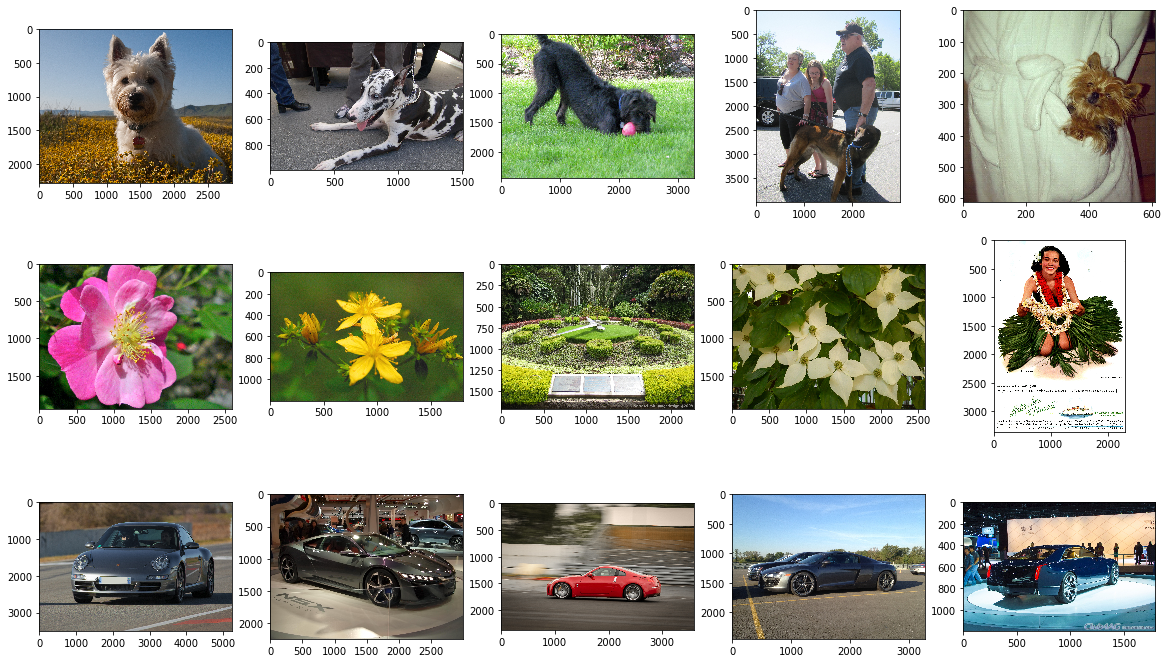

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 3
ncols = 5

fig = plt.figure()
fig.set_size_inches(ncols * 4, nrows * 4)

next_dog_pix = [os.path.join(test_dogs_dir, fname) for fname in dogs_fnames[:int(ncols*nrows/3)]]
next_flower_pix = [os.path.join(test_flowers_dir, fname) for fname in flowers_fnames[:int(ncols*nrows/3)]]
next_supercar_pix = [os.path.join(test_supercars_dir, fname) for fname in supercars_fnames[:int(ncols*nrows/3)]]

for i, img_path in enumerate(next_dog_pix + next_flower_pix + next_supercar_pix):
    sp = plt.subplot(nrows, ncols, i+1)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

# 2.1 Generating bottleneck features

Bottleneck features are esentially the ouptus of the convolutional part of our pretrained CNN, which will be the inputs of our new dense classification network. Genereating the bottleneck features will enable us to train the new dense part, without having to run all of the images through the CNN part every time. This saves us quite a lot of computational capacity (at the cost of loosing the ability to use image augmentation).

In theory, we could generate augmented bottleneck features, but getting the correct labels for these would be quite tricky, and the transfer learning seems to still perform very well without this.

In [0]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Activation, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from matplotlib import pyplot as plt

import numpy as np

Using TensorFlow backend.


In [0]:
# Original InceptionV3 uses input shape of 299x299, but we have to specify because include_top = false
model_InV3 = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (299, 299, 3))














87916544/87910968 [==============================] - 2s 0us/step


We don't need to generate the test bottleneck features, we'll only use our test dataset at the very end, where we've retrained all the network, not just the top layer.

In [0]:
# Use the built in InceptionV3 image preprocessing method
imDataGen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [0]:
#Create a generator for the training images
train_generator = imDataGen.flow_from_directory(directory = train_dir,
                                                target_size = (299, 299),
                                                shuffle = False, # We want to keep the order for now to be able to generate the labels easier in the future.
                                                batch_size = 1, # Batch size = 1 means we won't have to worry about all of our images fitting into integer number of batches
                                                class_mode = None) # We'll have to generate our own labels when using the bottleneck method
train_bottleNeck = model_InV3.predict_generator(generator = train_generator, verbose = 1)
np.save('train_bottleNeck.npy', train_bottleNeck)

Found 1200 images belonging to 3 classes.
1200/1200 [==============================] - 129s 107ms/step


In [0]:
validate_generator = imDataGen.flow_from_directory(directory = validate_dir,
                                                   target_size = (299, 299),
                                                   shuffle = False,
                                                   batch_size = 1,
                                                   class_mode = None)
validate_bottleNeck = model_InV3.predict_generator(generator = validate_generator, verbose = 1)
np.save('validate_bottleNeck.npy', validate_bottleNeck)

Found 300 images belonging to 3 classes.
300/300 [==============================] - 31s 104ms/step


Define a very simple dense classification network for 3 classes

In [0]:
def build_top_model(input_shape, dense_layer_size):
    model = Sequential()

    model.add(Flatten(input_shape = input_shape))
    model.add(Dense(dense_layer_size, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax')) # Softmax for classification

    return model

This next cell will generate the correct labels, because we set ```shuffle = False```.

In [0]:
train_bottleNeck = np.load('train_bottleNeck.npy')
train_labels = np.repeat(np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]), [400], axis = 0)

validate_bottleNeck = np.load('validate_bottleNeck.npy')
validate_labels = np.repeat(np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]), [100], axis = 0)

## 2.2 Training the top dense classification layer

Callbacks for training the dense layer:

In [0]:
early_stopping = EarlyStopping(patience = 20, verbose = 1)
checkpointer =  ModelCheckpoint(filepath = 'top_model.hdf5', save_best_only = True)
logger = CSVLogger('top_model_training.log')

Build the top dense layer. Loss function have to be categorical crossentropy, because we have 3 classes.

In [0]:
top_model = build_top_model(train_bottleNeck.shape[1:], 32)
top_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4194336   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 4,194,435
Trainable params: 4,194,435
Non-trainable params: 0
_________________________________________________________________


Train the dense classification layer:

In [0]:
history = top_model.fit(train_bottleNeck, train_labels,
                    epochs = 1000,
                    batch_size = 8,
                    verbose = 1,
                    shuffle = True,
                    validation_data = (validate_bottleNeck, validate_labels),
                    callbacks = [checkpointer, early_stopping, logger])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1200 samples, validate on 300 samples
Epoch 1/1000
1200/1200 [==============================] - 3s 2ms/step - loss: 3.4245 - acc: 0.7333 - val_loss: 0.1571 - val_acc: 0.9733
Epoch 2/1000
1200/1200 [==============================] - 1s 994us/step - loss: 0.4103 - acc: 0.8442 - val_loss: 0.0823 - val_acc: 0.9667
Epoch 3/1000
1200/1200 [==============================] - 1s 1ms/step - loss: 0.4422 - acc: 0.8650 - val_loss: 0.1020 - val_acc: 0.9667
Epoch 4/1000
1200/1200 [==============================] - 1s 1ms/step - loss: 0.3108 - acc: 0.8683 - val_loss: 0.0937 - val_acc: 0.9900
Epoch 5/1000
1200/1200 [==============================] - 1s 1ms/step - loss: 0.3632 - acc: 0.8592 - val_loss: 0.1740 - val_acc: 0.9833
Epoch 6/1000
1200/1200 [==============================] - 1s 1ms/step - loss: 0.4506 - acc: 0.8733 - val_loss: 0.1353 - val_acc: 0.9833
Epoch 7/1000
1200/1200 [===============

Our training yielded a a 99.3% percent validation accuracy (which is 2 misclassified images out of the 300 validation images), pretty good.

Plot the accuracy during the training.

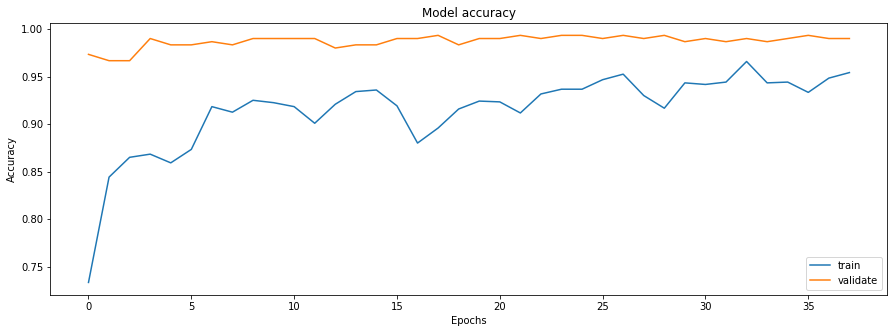

In [0]:
plt.figure(figsize = (15,5))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validate'], loc='lower right')

plt.show()

## 2.3 Fine tuning the CNN

Train the pretrained top layers and the upper partsd of InceptionV3.

Creating the data generators for the training. This time, we are free to use image augmentation. Validation images can also be augmented (this somewhat avoids the being overfitted to the non-augmented version from training the dense part on them.

In [0]:
# Data Generator with augmentations
aug_imDataGen = ImageDataGenerator(rotation_range = 90,  
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     preprocessing_function = preprocess_input)

train_generator = aug_imDataGen.flow_from_directory(directory = train_dir,
                                                    target_size = (299, 299),
                                                    shuffle = True,
                                                    batch_size = 16, #Default batch size of 32 will not divied 1200, but we want to use all 1200 images to validate --> batch size of 16 will yield 75 batches
                                                    class_mode = 'categorical')

validate_generator = aug_imDataGen.flow_from_directory(directory = validate_dir,
                                                       target_size = (299, 299),
                                                       shuffle = True,
                                                       batch_size = 4, #Default batch size of 32 will not divied 300, but we want to use all 300 images to validate --> batch size of 4 will yield 75 batches
                                                       class_mode = 'categorical')

# There's really no need to use augmentation on the test images, the network will not see these untill being finished with training.
test_generator = imDataGen.flow_from_directory(directory = test_dir,
                                               target_size = (299, 299),
                                               shuffle = False, # Otherwise we can't generate the correct labels for the ground trut for evaluation by hand (e.g. confusion matrix)
                                               batch_size = 4,
                                               class_mode = 'categorical')

Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


Building the full model. As we are only fine tuning at this point, the SGD optimezer will be used, with a very low learning rate.

In [0]:
def build_full_model(bottom_model, top_model_weights_path, dense_layer_size):
    model = Sequential()

    model.add(bottom_model) # CNN part of InceptionV3
  
    top_model = build_top_model(bottom_model.output_shape[1:], dense_layer_size)
    top_model.load_weights(top_model_weights_path) # Load the pretrained Dense part weights
    model.add(top_model)

    # Compile model with low learning rate SGD
    model.compile(optimizer = SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [0]:
 # Freeze the lower parts of InceptionV3, we only want to fine tune the more abstract feature extraction parts.
 # The boundary for trainable / non trainable layers is based on the practice of week 7.
for layer in model_InV3.layers[:172]:
    layer.trainable = False
for layer in model_InV3.layers[172:]:
    layer.trainable = True

full_model = build_full_model(model_InV3, 'top_model.hdf5', 32)
full_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
sequential_3 (Sequential)    (None, 3)                 4194435   
Total params: 25,997,219
Trainable params: 20,410,371
Non-trainable params: 5,586,848
_________________________________________________________________


Callbacks for the full model training:

In [0]:
early_stopping = EarlyStopping(patience = 5, verbose = 1)
checkpointer =  ModelCheckpoint(filepath = 'full_model.hdf5', save_best_only = True)
logger = CSVLogger('InV3_model_training.log')

Fine tune the model:

In [0]:
history = full_model.fit_generator(train_generator,
                    epochs = 50,
                    verbose = 1,
                    shuffle = True,
                    validation_data = validate_generator,
                    callbacks = [checkpointer, early_stopping, logger])

Epoch 1/50
75/75 [==============================] - 174s 2s/step - loss: 0.7833 - acc: 0.7225 - val_loss: 0.1046 - val_acc: 0.9500
Epoch 2/50
75/75 [==============================] - 147s 2s/step - loss: 0.4458 - acc: 0.7883 - val_loss: 0.0852 - val_acc: 0.9600
Epoch 3/50
75/75 [==============================] - 148s 2s/step - loss: 0.3940 - acc: 0.8192 - val_loss: 0.0497 - val_acc: 0.9800
Epoch 4/50
75/75 [==============================] - 147s 2s/step - loss: 0.3516 - acc: 0.8333 - val_loss: 0.0609 - val_acc: 0.9833
Epoch 5/50
75/75 [==============================] - 145s 2s/step - loss: 0.3415 - acc: 0.8433 - val_loss: 0.0524 - val_acc: 0.9800
Epoch 6/50
75/75 [==============================] - 144s 2s/step - loss: 0.3597 - acc: 0.8383 - val_loss: 0.0439 - val_acc: 0.9800
Epoch 7/50
75/75 [==============================] - 144s 2s/step - loss: 0.3252 - acc: 0.8392 - val_loss: 0.0495 - val_acc: 0.9800
Epoch 8/50
75/75 [==============================] - 145s 2s/step - loss: 0.3399 - a

Plot the accuracy during training:

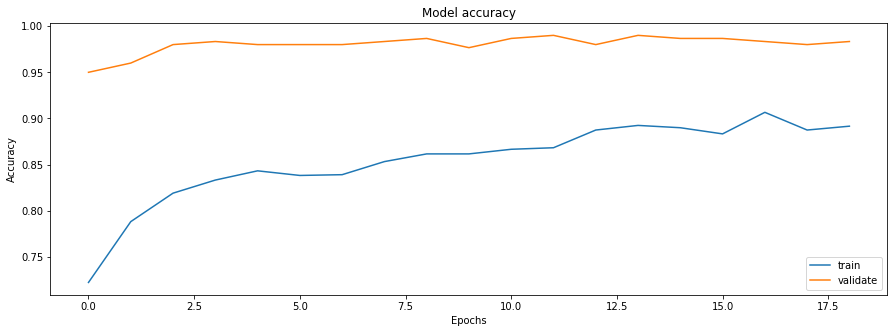

In [0]:
plt.figure(figsize = (15,5))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validate'], loc='lower right')

plt.show()

## 2.4 Evaluate the final model

In [0]:
full_model = load_model("full_model.hdf5") # Load back the best state of the model

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
# Create predictions for the test images
test_preds = full_model.predict_generator(test_generator, verbose = 1)
test_preds = np.argmax(test_preds, 1)
# Ground truth labels for the test images (this works because shuffle = False)
test_true = test_generator.labels

print("Test accuracy: %g" %(accuracy_score(test_true, test_preds)))
print("Precision", precision_score(test_true, test_preds, average="macro"))
print("Recall", recall_score(test_true, test_preds, average="macro"))
print("f1_score", f1_score(test_true, test_preds, average="macro"))

75/75 [==============================] - 26s 353ms/step
Test accuracy: 0.993333
Precision 0.9933663366336635
Recall 0.9933333333333333
f1_score 0.9933332499979165


Plot a confusion matrix:

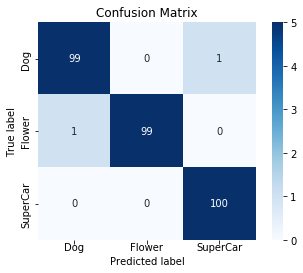

In [0]:
conf=confusion_matrix(test_true, test_preds)

import seaborn as sns

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect(1)

res = sns.heatmap(conf, annot=True, vmin=0.0, vmax=5.0, fmt='d', cmap = plt.get_cmap('Blues'))

plt.yticks([0.5,1.5,2.5], [ 'Dog', 'Flower', 'SuperCar'],va='center')
plt.ylim([0, 3])
plt.ylabel('True label')
plt.xticks([0.5,1.5,2.5], [ 'Dog', 'Flower', 'SuperCar'],va='center')
plt.xlim([0, 3])
plt.xlabel('Predicted label')

res.invert_yaxis()

plt.title('Confusion Matrix')

plt.show()

As the confusion matrix shows, there's only two images that has been misclassified (it seems it's supposed to be a dog which is classified as a supercar, and a flower classified as a dog), which is excellent. Let's find the images!

In [0]:
truth = (test_preds != test_true)
misClass_images = np.array(test_generator.filepaths)[np.array(truth)]

assignment04_img/test/dog/f76732e4ab7d144c.jpg
Predicted class confidences are: [[2.2223579e-05 2.5113394e-13 9.9997783e-01]] ([1 0 0] = dog, [0 1 0] = flower, [0 0 1] = supercar)


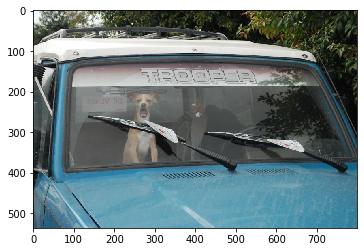

assignment04_img/test/flower/3287fcb539ba2915.jpg
Predicted class confidences are: [[0.5694056  0.28867248 0.14192185]] ([1 0 0] = dog, [0 1 0] = flower, [0 0 1] = supercar)


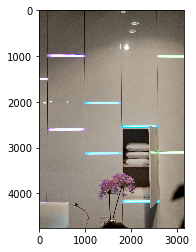

In [0]:
for file_path in misClass_images:
    print(file_path)
    in_image = image.load_img(file_path, target_size= (299, 299))
    inp = image.img_to_array(in_image)
    inp = preprocess_input(inp)
    inp = np.expand_dims(inp, axis=0)

    pred = full_model.predict(inp)
    print('Predicted class confidences are: {} ([1 0 0] = dog, [0 1 0] = flower, [0 0 1] = supercar)'.format(pred))

    plt.figure()
    plt.imshow(image.load_img(file_path))
    plt.show()

Seeing the first image, it is quite understandable why this 'dog' was labeled a 'supercar' (even though it's not much of a 'super' car, our CNN doesn't know any other type of car).

As for the second image, the prediction was not as clear cut, as it was for the first one: only 57% confidence in it being a dog, and 29% confidence in it being a flower. The actual flower occupies only a a small portion of the whole image.

Given these, we can say that the network performed near perfectly on the chosen 3 classes (although the 3 classes are really not similar, so the task is not that difficult).